# Prototype of VEM in M&M ASH model
This is the VEM step of M&M ASH model.

$\newcommand{\bs}[1]{\boldsymbol{#1}}$
$\DeclareMathOperator*{\diag}{diag}$
$\DeclareMathOperator*{\cov}{cov}$
$\DeclareMathOperator*{\rank}{rank}$
$\DeclareMathOperator*{\var}{var}$
$\DeclareMathOperator*{\tr}{tr}$
$\DeclareMathOperator*{\veco}{vec}$
$\DeclareMathOperator*{\uniform}{\mathcal{U}niform}$
$\DeclareMathOperator*{\argmin}{arg\ min}$
$\DeclareMathOperator*{\argmax}{arg\ max}$
$\DeclareMathOperator*{\N}{N}$
$\DeclareMathOperator*{\gm}{Gamma}$
$\DeclareMathOperator*{\dif}{d}$

## M&M ASH model

We assume the following multivariate, multiple regression model with $N$ samples, $J$ effects and $R$ conditions (and **without covariates, for the time being**)
\begin{align}
\bs{Y}_{N\times R} = \bs{X}_{N \times J}\bs{B}_{J \times R} + \bs{E}_{N \times R},
\end{align}
where
\begin{align}
\bs{E} &\sim \N_{N \times R}(\bs{0}, \bs{I}_N, \bs{\Lambda}^{-1}),\\
\bs{\Lambda} &= \diag(\lambda_1,\ldots,\lambda_R).
\end{align}

We assume true effects $\bs{b}_j$ (rows of $\bs{B}$) are iid with prior distribution of mixtures of multivariate normals

$$p(\bs{b}_j) = \sum_{t = 0}^T\pi_t\N_R(\bs{b}_j | \bs{0}, \bs{V}_t),$$

Where the $\bs{V}_t$'s are $R \times R$ covariance matrices and the $\pi_t$'s are their weights.

We place Gamma prior on $\bs{\Lambda}$

$$\lambda_r \overset{iid}{\sim} \gm(\alpha, \beta),$$

and set $\alpha = \beta = 0$ so that it is equivalent to estimating $\bs{\Lambda}$ via maximum likelihood.

We can augment the prior of $\bs{b}_j$ by indicator vector $\bs{\gamma}_j \in \mathbb{R}^T$ for membership of $\bs{b}_j$ into one of the $T$ mixture groups. The densities involved are

\begin{align}
p(\bs{Y},\bs{B},\bs{\Gamma},\bs{\Lambda}) &= p(\bs{Y}|\bs{B}, \bs{\Lambda})p(\bs{B}|\bs{\Gamma})p(\bs{\Gamma})p(\bs{\Lambda}), \\
p(\bs{Y}|\bs{B}, \bs{\Lambda}) &= N_{N \times R}(\bs{X}\bs{B}, \bs{I}_N, \bs{\Lambda}^{-1}), \\
p(\lambda_r|\alpha,\beta) &= \frac{\beta^{\alpha}}{\Gamma(\alpha)}\lambda_r^{\alpha - 1}\exp\{-\beta\lambda_r\}, \\
p(\bs{b}_j|\bs{\gamma}_j) &= \prod_{t = 0}^T\left[\N(\bs{b}_j|\bs{0},\bs{V}_t)\right]^{\gamma_{jt}},\\
p(\bs{\gamma}_j) &= \prod_{t = 0}^{T} \pi_t^{\gamma_{jt}}.
\end{align}

**We assume $V_t$'s and their corresponding $\pi_t$'s are known. In practice we use `mashr` to estimate these quantities and provide them to M&M.**

### Variational approximation to densities

For the posterior of $\bs{B}$ we seek an independent variational approximation based on

\begin{align}
q(\bs{B}, \bs{\Gamma}, \bs{\Lambda}) = q(\bs{\Lambda})\prod_{j = 1}^{J}q(\bs{b}_j,\bs{\gamma}_j),
\end{align}

so that we can maximize over $q$ the following lower bound of the marginal log-likelihood

\begin{align}
\log p(\bs{Y}) \geq \mathcal{L}(q) = \int q(\bs{B}, \bs{\Gamma}, \bs{\Lambda}) \log\left\{\frac{p(\bs{Y},\bs{B},\bs{\Gamma},\bs{\Lambda})}{q(\bs{B}, \bs{\Gamma}, \bs{\Lambda})}\right\}\dif\bs{B}\dif\bs{\Gamma}\dif\bs{\Lambda},
\end{align}

Gao & Wei have previously developed [a version that assumes $\Lambda = I_R$](https://github.com/gaow/mvarbvs/blob/master/writeup/identity_cov/mnmash.pdf). This version generalized it to a diagonal matrix with Gamma priors. [David has developed a version](https://www.overleaf.com/11985539jvwgjhrqnrry#/45465793/) that assumes a diagonal plus low rank structure -- the model of that version is a bit different from shown here, and will be prototyped later after this version works.

### Core updates

The complete derivation of updates are documented elsewhere (in the two PDF write-ups whose links are shown above). Here I document core updates to guide implementation of the algorithm.

Let $E[\bs{R}_{-j}] := \bs{Y} - \bs{X}\bs{\mu}_{\bs{B}} + \bs{x}_j\bs{\mu}_{\bs{B}[j, ]}^{\intercal}$, then


\begin{align}
\bs{\xi}_j &= E\left[\bs{R}_{-j}\right]^{\intercal}\bs{x}_j\|\bs{x}_j\|^{-2}, \\
\bs{\Sigma}_{jt} &= \left(\bs{V}_t^{-1} + \|\bs{x}_j\|^2\bs{\Lambda}\right)^{-1}, \\
\bs{\mu}_{jt} &= \bs{\Sigma}_{jt}\bs{\Lambda}E\left[\bs{R}_{-k}\right]^{\intercal}\bs{x}_j, \\
w_{jt} &= \frac{\pi_t\N(\bs{\xi}_j|\bs{0}, \bs{V}_t + \bs{\Lambda}^{-1}\|\bs{x}_j\|^{-2})}{\sum_{t = 0}^T\pi_t\N(\bs{\xi}_j|\bs{0}, \bs{V}_t + \bs{\Lambda}^{-1}\|\bs{x}_j\|^{-2})},\\
\bs{\mu}_{\bs{B}[j, ]}  &= \sum_{t = 0}^T w_{jt}\bs{\mu}_{jt}
\end{align}

We update until the lower bound $\mathcal{L}(q)$ converges.

## Initialization

* We fit `mashr` with effects learned from univariate analysis to obtain $\pi_t$ and $V_t$
  * For the first round the effects are "LD-polluted"
* Use multivariate LASSO to get the ordering of $X$ for input. Similar approach has been previousely used with `varbvs`.
* We "stack" expression data under multiple conditions and impute missing data with mean imputation or `softImpute` for a completed $Y$ matrix.
  * This version of the model does not impute missing data in $Y$ in its variational updates although this will be added in next version.
* We regress out covariates beforehand
  * Same approach taken by Guan & Stephens 2011 yet not Carbonetto & Stephens 2012
  * In next version we will preprocess covariates by "stacking" them together and perform a low-rank decomposition / imputation. For example for 50 tissues there will be a blocked matrix with a total of over 1000 PEER factors when stacked together, with non-random missing data. We will perform a low rank approximation to hopefully only keep < 50 PEER. We will then control for covariates in the M&M model.
  
**In this notebook we use a test data set of 2 tissues: Thyroid and Lung. As a first pass we also fix $\bs{V}$ as a null matrix plus an identity matrix, with weights and $\pi_0=0.9$.**

In [1]:
dat = readRDS('/home/gaow/Documents/GTExV8/Thyroid.Lung.FMO2.filled.rds')
str(dat)
attach(dat)

List of 2
 $ Y:'data.frame':	698 obs. of  2 variables:
  ..$ Thyroid: num [1:698] 0.163 0.436 -0.212 0.327 -0.698 ...
  ..$ Lung   : num [1:698] 0.77011 0.77799 -0.65361 0.00672 -0.36792 ...
 $ X: num [1:698, 1:7492] 1 0 0 0 0 1 1 0 1 1 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:698] "GTEX-111CU" "GTEX-111FC" "GTEX-111VG" "GTEX-111YS" ...
  .. ..$ : chr [1:7492] "chr1_170185243_G_A_b38" "chr1_170185272_T_C_b38" "chr1_170185405_C_A_b38" "chr1_170185417_G_A_b38" ...


In [2]:
%get X Y --from R
import numpy as np
from scipy.stats import multivariate_normal

Loading required package: feather


## Data preview

In [3]:
X

array([[ 1.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  1.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [4]:
Y = Y.as_matrix()

In [5]:
Y

array([[ 0.16348104,  0.77010917],
       [ 0.43588995,  0.77798736],
       [-0.21237311, -0.65361193],
       ..., 
       [ 0.62036618, -0.0035004 ],
       [ 0.00279156, -0.05439095],
       [-0.14650835,  0.29935286]])

## Multivariate LASSO 
For initialization of effects. Here I use implementation via `sklearn`, as documented [here](http://scikit-learn.org/stable/modules/linear_model.html#multi-task-lasso). It is quite slow to compute a proper CV version of LASSO, though.

In [6]:
from sklearn import linear_model
import numpy as np
# model = linear_model.MultiTaskLassoCV(alphas = [(x+1)/100 for x in range(10)], fit_intercept = False)
model = linear_model.MultiTaskLasso(alpha = 0.04, fit_intercept = False)
model.fit(X, Y)

MultiTaskLasso(alpha=0.04, copy_X=True, fit_intercept=False, max_iter=1000,
        normalize=False, random_state=None, selection='cyclic', tol=0.0001,
        warm_start=False)

First feature:

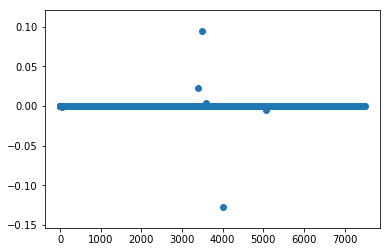

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.scatter([x+1 for x in range(len(model.coef_[0]))], model.coef_[0], cmap="viridis")
ax = plt.gca()
plt.show()

Second feature:

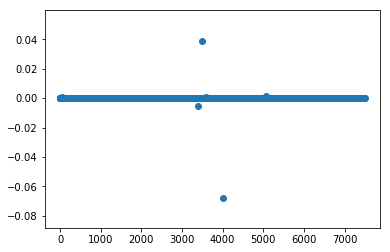

In [8]:
plt.scatter([x+1 for x in range(len(model.coef_[1]))], model.coef_[1], cmap="viridis")
ax = plt.gca()
plt.show()

First vs. 2nd feature:

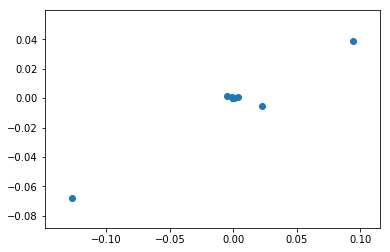

In [9]:
plt.scatter(model.coef_[0], model.coef_[1], cmap="viridis")
ax = plt.gca()
plt.show()

Compare with univariate LASSO, first and 2nd features:

In [10]:
# model = linear_model.LassoCV(alphas = [(x+1)/100 for x in range(10)], fit_intercept = False)
model = linear_model.Lasso(alpha = 0.05, fit_intercept = False)
model.fit(X,Y[:,0])

Lasso(alpha=0.05, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

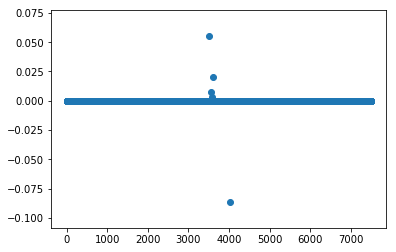

In [11]:
plt.scatter([x+1 for x in range(len(model.coef_))], model.coef_, cmap="viridis")
ax = plt.gca()
plt.show()

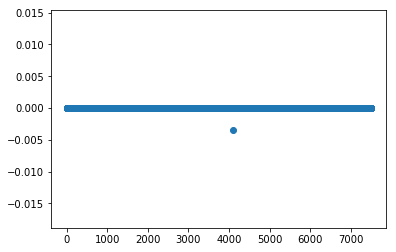

In [12]:
model.fit(X,Y[:,1])
plt.scatter([x+1 for x in range(len(model.coef_))], model.coef_, cmap="viridis")
ax = plt.gca()
plt.show()

## MASH priors and weights
As initialization we take univariate analysis summary statistics $\hat{\bs{B}}$ and $\bs{S}$ for fitting with `mashr`.

## VEM implementation
It is not working yet. Still trying to figure out what's going on.

In [13]:
class MNMASH:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y        
        self.B = np.zeros((X.shape[1], Y.shape[1]))
        # self.V = np.ones((2, Y.shape[1], Y.shape[1]))
        self.V = np.array((np.zeros((2,2)), np.identity(2)))
        # self.pi = np.random.uniform(0,1,self.V.shape[0])
        # self.pi = self.pi / sum(self.pi)
        self.pi = np.array([0.9, 0.1])
        self.Lambda = np.identity(Y.shape[1])
        self.tol = 1E-4
        self.debug = 1
        self.maxiter = 1
        # initialize intermediate variables
        self.R = np.ones((self.X.shape[1], self.Y.shape[0], self.Y.shape[1])) * np.nan
        self.E = np.ones((self.Y.shape[1], self.X.shape[1])) * np.nan
        self.Rx = np.ones((self.Y.shape[1], self.X.shape[1])) * np.nan
        self.wdE = np.ones((self.X.shape[1], self.V.shape[0])) * np.nan
        self.Sigma = {tt: np.ones((self.X.shape[1], self.Y.shape[1], self.Y.shape[1])) * np.nan for tt in range(self.V.shape[0])}
        self.Mu = np.ones((self.X.shape[1], self.Y.shape[1], self.V.shape[0])) * np.nan
        self.gamma = np.ones((self.X.shape[1], self.V.shape[0])) * np.nan
        # X is N by K matrix, X_norm is 1 by K vector of L2 norm of column k's
        self.X_norm = np.linalg.norm(self.X, ord = 2, axis = 0)
        if self.debug:
            self.X_std = self.X / self.X_norm
            np.testing.assert_array_almost_equal(np.sum(np.square(self.X_std), axis = 0), np.ones(self.X.shape[1]))
        self.X_norm = np.square(self.X_norm)
        self.X_std = self.X / self.X_norm
        self.R_all = None
        self.H = None
        self.Delta = None
        self.update_lambda = True

    def update(self):
        '''
        Core update
        '''
        iLambda = np.linalg.inv(self.Lambda)
        # B is M by K matrix
        self.R_all = self.Y - self.X @ self.B
        # K is number of effects
        for kk in range(self.X.shape[1]):
            # R[kk] is N x M, where M is number of conditions
            self.R[kk,:,:] = self.R_all + np.outer(self.X[:,kk], (self.B[kk,:].T))
            # E[kk] is M x 1
            self.E[:,kk] = (self.R[kk,:,:].T @ self.X_std[:,kk]).ravel()
            # Rx[kk] is M x 1
            self.Rx[:,kk] = (self.R[kk,:,:].T @ self.X[:,kk]).ravel()
            for tt in range(self.V.shape[0]):
                self.wdE[kk,tt] = multivariate_normal.pdf(self.E[:,kk], np.zeros(self.Y.shape[1]), \
                                                          self.V[tt] + iLambda / self.X_norm[kk]) * self.pi[tt]
            wdE_sum = sum(self.wdE[kk,:])
            for tt in range(self.V.shape[0]):
                # Can be made faster via low-rank approximation
                self.Sigma[tt][kk,:,:] = np.linalg.inv(np.identity(self.Y.shape[1]) + self.V[tt] * self.X_norm[kk] @ self.Lambda) @ self.V[tt]
                self.Mu[kk,:,tt] = self.Sigma[tt][kk,:,:] @ self.Lambda @ self.Rx[:,kk]
                self.gamma[kk,tt] = self.wdE[kk,tt] / wdE_sum
                #if self.gamma[kk,tt] != self.gamma[kk,tt]:
                #    self.gamma[kk,tt] = 0
            # dot product for weighted sums
            self.B[kk,:] = self.Mu[kk,:,:] @ self.gamma[kk,:]
        if self.update_lambda:
            # Recalculate h, a M by M matrix
            self.H = np.diag(np.sum([self.X_norm[kk] * np.sum([self.gamma[kk,tt] * (np.square(self.Mu[kk,:,tt] - self.B[kk,:]) + np.diag(self.Sigma[tt][kk,:,:])) for tt in range(self.V.shape[0])], axis = 0) for kk in range(self.X.shape[1])], axis = 0))
            # Update Lambda
            self.Delta = np.diag(self.R_all.T @ self.R_all) + self.H
            self.Lambda = np.diag(self.X.shape[0] / np.diag(self.Delta))

    def vem(self):
        '''
        Variational EM
        '''
        cnt = 0
        while cnt < self.maxiter:
            self.update()
            cnt += 1

    def summary(self):
        self.prt('R')
        self.prt('E')
        self.prt('Rx')
        self.prt('wdE')
        self.prt('Sigma')
        self.prt('Mu')
        self.prt('gamma')
        self.prt('B')
        self.prt('H')
        self.prt('Delta')
        self.prt('Lambda')
        print('X @ B = \n{}\n'.format(self.X @ self.B))
        print('Y - X @ B = \n{}\n'.format(self.Y - self.X @ self.B))

    def prt(self, variable):
        print(variable, '=', repr(eval(f'self.{variable}')))
        print('\n')

In [57]:
res = MNMASH(X,Y)

## Checking core updates

First iteration.

In [58]:
res.update()

In [59]:
res.summary()

R = array([[[ 0.16348104,  0.77010917],
        [ 0.43588995,  0.77798736],
        [-0.21237311, -0.65361193],
        ..., 
        [ 0.62036618, -0.0035004 ],
        [ 0.00279156, -0.05439095],
        [-0.14650835,  0.29935286]],

       [[ 0.16348104,  0.77010917],
        [ 0.43588995,  0.77798736],
        [-0.21237311, -0.65361193],
        ..., 
        [ 0.62036618, -0.0035004 ],
        [ 0.00279156, -0.05439095],
        [-0.14650835,  0.29935286]],

       [[ 0.16348104,  0.77010917],
        [ 0.43588995,  0.77798736],
        [-0.21237311, -0.65361193],
        ..., 
        [ 0.62036618, -0.0035004 ],
        [ 0.00279156, -0.05439095],
        [-0.14650835,  0.29935286]],

       ..., 
       [[ 0.16348104,  0.77010917],
        [ 0.43588995,  0.77798736],
        [-0.21237311, -0.65361193],
        ..., 
        [ 0.62036618, -0.0035004 ],
        [ 0.00279156, -0.05439095],
        [-0.14650835,  0.29935286]],

       [[ 0.16348104,  0.77010917],
        [ 0.4358899

Second iteration.

In [60]:
res.update()

In [61]:
res.summary()

R = array([[[ 0.13052478,  0.7590064 ],
        [ 0.17856335,  0.71408075],
        [ 1.71897477,  0.16879088],
        ..., 
        [ 0.65640522,  0.03414318],
        [-0.05631698, -0.06517789],
        [-0.12817637,  0.32152677]],

       [[ 0.13053486,  0.75901662],
        [ 0.17856335,  0.71408075],
        [ 1.71884308,  0.16868293],
        ..., 
        [ 0.65640522,  0.03414318],
        [-0.05631698, -0.06517789],
        [-0.12817637,  0.32152677]],

       [[ 0.13053486,  0.75901662],
        [ 0.17856335,  0.71408075],
        [ 1.71897477,  0.16879088],
        ..., 
        [ 0.65640522,  0.03414318],
        [-0.05631698, -0.06517789],
        [-0.12817637,  0.32152677]],

       ..., 
       [[ 0.13053486,  0.75901662],
        [ 0.17856335,  0.71408075],
        [ 1.71897477,  0.16879088],
        ..., 
        [ 0.65640522,  0.03414318],
        [-0.05631698, -0.06517789],
        [-0.12817637,  0.32152677]],

       [[ 0.13053327,  0.75902051],
        [ 0.1785617

In [62]:
np.min(res.wdE)

5.604973192572156e-166

In [63]:
np.min(res.gamma)

1.0062197120752165e-163

3rd iteration.

In [64]:
res.update()
res.summary()

/home/gaow/Public/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


R = array([[[-452.68031051, -260.85067572],
        [-329.9030039 , -198.17133042],
        [-529.86574394, -299.99456245],
        ..., 
        [-553.88194259, -309.24290189],
        [-432.8063047 , -252.80819391],
        [-350.84286708, -204.11494232]],

       [[-452.89077841, -260.96589542],
        [-329.9030039 , -198.17133042],
        [-529.84909793, -299.98637649],
        ..., 
        [-553.88194259, -309.24290189],
        [-432.8063047 , -252.80819391],
        [-350.84286708, -204.11494232]],

       [[-452.89077841, -260.96589542],
        [-329.9030039 , -198.17133042],
        [-529.86574394, -299.99456245],
        ..., 
        [-553.88194259, -309.24290189],
        [-432.8063047 , -252.80819391],
        [-350.84286708, -204.11494232]],

       ..., 
       [[-452.89077841, -260.96589542],
        [-329.9030039 , -198.17133042],
        [-529.86574394, -299.99456245],
        ..., 
        [-553.88194259, -309.24290189],
        [-432.8063047 , -252.80819391],
 